# Random Forest Regression
---

# Load packages and data

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Regression
from sklearn.model_selection import train_test_split # split data into train and test sets
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # calculate model performance
from sklearn.ensemble import RandomForestRegressor # random forest model
from sklearn.model_selection import RepeatedKFold # perform cross-validation for tuning the penalty parameter
from sklearn.model_selection import GridSearchCV # perform cross-validation for tuning the penalty parameter
from sklearn.inspection import permutation_importance # calculate permutation importance scores

df = pd.read_csv('/home/simon/Predict_House_Prices/kc_house_data_cleaned_featured.csv', index_col=0)
df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bedrooms_sqft_living,bathrooms_floors,renovated
0,7129300520,13-10-2014,221900.0,3,1.00,1180,5650,1.0,0,0,...,1955,0,98178,47.5112,-122.257,1340,5650,0.002542,1.000,0
1,6414100192,09-12-2014,538000.0,3,2.25,2570,7242,2.0,0,0,...,1951,1991,98125,47.7210,-122.319,1690,7639,0.001167,1.125,1
2,5631500400,25-02-2015,180000.0,2,1.00,770,10000,1.0,0,0,...,1933,0,98028,47.7379,-122.233,2720,8062,0.002597,1.000,0
3,2487200875,09-12-2014,604000.0,4,3.00,1960,5000,1.0,0,0,...,1965,0,98136,47.5208,-122.393,1360,5000,0.002041,3.000,0
4,1954400510,18-02-2015,510000.0,3,2.00,1680,8080,1.0,0,0,...,1987,0,98074,47.6168,-122.045,1800,7503,0.001786,2.000,0


# Prepare data for model

In [2]:
# Create dummy features for categorical variables
df_dummy = pd.get_dummies(df, prefix='Category_', columns=['zipcode'])

# Define dependent variables by dropping unneeded features
X_dummy = df_dummy.drop(columns=['id', 'date', 'price', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'bedrooms_sqft_living', 'bathrooms_floors'], axis=1)

# Define independent variable
y = df['price']

# Split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_dummy, y, test_size=0.25, random_state=1)

# Random Forest Regression

## Model tuning

In [3]:
# Create a base model
rf = RandomForestRegressor(random_state = 1)

# K-Fold Cross-Validation
cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=1)

# Create the parameter grid
grid = {
    'max_features': list(range(1,21)),
    'n_estimators': [500]
}

# Define grid search
search = GridSearchCV(rf, grid, cv=cv, n_jobs=4)

# Perform search
search.fit(X_train, y_train)

/home/simon/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=3, random_state=1),
             estimator=RandomForestRegressor(random_state=1), n_jobs=4,
             param_grid={'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20],
                         'n_estimators': [500]})

In [4]:
# Select the best parameters of the model
best_params = search.best_params_
best_params

{'max_features': 1, 'n_estimators': 500}

## Train and test model

In [5]:
# Define tuned model
tunedRf = RandomForestRegressor(**best_params, random_state=1)
tunedRf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = tunedRf.predict(X_test)

In [6]:
# Calculate the error scores and R² on the test set
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R²:', r2_score(y_test, y_pred))

Mean Absolute Error: 81485.88469900543
Mean Squared Error: 32959796338.57278
Root Mean Squared Error: 181548.33058602543
R²: 0.7941574482208017


## Permutation importance scores

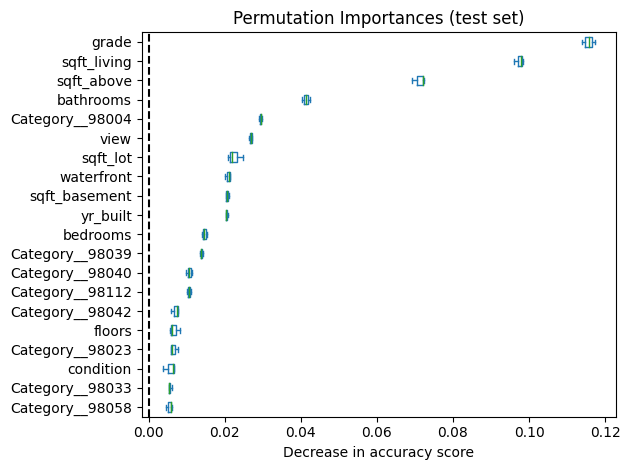

In [7]:
result = permutation_importance(
    tunedRf, X_test, y_test, n_repeats=3, random_state=1, n_jobs=1)
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_dummy.columns[sorted_importances_idx],
).iloc[:,-20:]
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

# Comments
- Best to sample 1 feature per tree
- Random Forest performs better than previous models
- Grade, size and number of bathrooms are the most important features